---
title: "Predicting reply under comment with LLM"
date: 2024/05/21
date-modified: 2024/08/24
description: "Finetuning of Camembert on predicting, using a Le Soleil Facebook post comment as input, whether it will receive a response or not."
categories:
  - Tutorial
format: 
  html:
    code-fold: true
jupyter: python3
---

## Context

This project originally started as a school assignment for Big Data class. The notebook presented here demonstrates the use of a large language model (LLM) to tackle a binary classification problem. Specifically, our objective is to predict whether a comment will receive a response or not.

To achieve this, we use an enriched dataset compiled from comments on Le Soleil's Facebook posts. I will also share a separate notebook detailing the process of building this dataset. Additionally, I plan to publish another post explaining how to utilize simple feedforward neural networks or statistical models based on various comment features or the comment text itself.

Let's dive in!

## Dependence

I prefer to set aside the cell that install system dependency. It always produces a lot of useless gx3di3ce... You get it, right ?

In [ ]:
!pip install torchsampler
!pip install sacremoses

Now, let's import some packages to have fun !

In [2]:
import transformers, torch
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
import time

from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from torchsampler import ImbalancedDatasetSampler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from IPython.display import clear_output

# warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mp.cpu_count() # used to set the number of num_worker for Dataloader, usually the half of it 

And since I use Google colab, I mount my drive to load the datasets later.

In [3]:
#| code-fold: false

# only if you are using Google colab of course...
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## About our datasets

In this section, we will explore the dataset used for our binary classification problem. The dataset has been divided into training and testing sets, with 70% of the data allocated for training and the remaining 30% for testing. This split ensures that we have a robust training set to build our model while retaining a sufficient portion of the data for evaluating the model's performance. 

Let's load the train and the test sets.

In [ ]:
#| code-fold: false

dirpath = '/content/drive/MyDrive/DataSets/big_data/datasets' # specify here the path to the dataset
train = pd.read_csv(dirpath + '/split/train_dataset.csv', index_col=0)
test = pd.read_csv(dirpath + '/split/valid_dataset.csv', index_col=0)

A few statistics about our dataset. First of all, it contains almost a million rows. 

In [5]:
dataset = pd.concat([train, test])
print(f'Dataset shape: {dataset.shape}')

Dataset shape: (935698, 68)


Secondly, the dataset is highly unbalanced. The following graph shows that there are only ~13% of comments with replies, by which I mean that these comments have received at least one comment.

In [6]:
dataset['target'].value_counts(normalize=True)

target
False    0.876036
True     0.123964
Name: proportion, dtype: float64

<Axes: xlabel='target'>

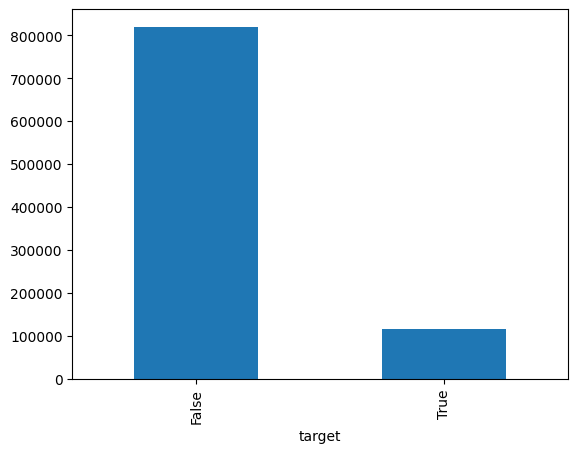

In [7]:
#| label: fig-cap-margin0
#| fig-cap: "Barchart of the count of each class"

dataset['target'].value_counts().plot(kind='bar')

We have then two significant issues. Firstly, running the training on the entire dataset would be extremely time-consuming, even with substantial computational resources. Secondly, our dataset is unbalanced, which presents a challenge for accurate model training. 

To address these issues, I opted for undersampling, ensuring an equal number of items from each class. This approach allows us to run our experiments more efficiently and mitigates the problem of data imbalance. Later in the notebook, we will explore the impact of the amount of data used on the model's performance.

## Class and functions

I write the CommentDataset class as a custom dataset designed for handling text data. It inherits from the Dataset class provided by PyTorch. This class is specifically tailored for tokenizing and preparing text data along with their corresponding labels for use in a model.

In [8]:
class CommentDataset(Dataset):
    def __init__(self, message, labels, tokenizer):
        self.message = message
        self.labels = labels
        self.tokenizer = tokenizer

    def get_labels(self):
        return self.labels

    def __len__(self):
        return len(self.message)

    def __getitem__(self, idx):
        text = self.message[idx]
        label = self.labels[idx]

        inputs = self.tokenizer.encode_plus(text, None, add_special_tokens=True, padding='max_length', return_token_type_ids=True, truncation=True)

        return {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs["token_type_ids"], dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.float)
        }

The `train_model` method is designed to train a machine learning model using a provided training and testing dataloader, while tracking various performance metrics such as loss, accuracy, precision, recall, and a custom F2 score across multiple epochs, and implementing early stopping based on validation performance. The `test_model` method evaluates the trained model on a validation dataset, computing and printing evaluation metrics to assess the model's performance.

In [19]:
def train_model(model, train_dataloader, test_dataloader, history={}, num_epochs=5, lr=5e-5, early_stopping_patience=3, weight_decay=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1)  # ReduceLROnPlateau scheduler
    loss_fn = torch.nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss

    history['train_loss'] = []
    history['train_accuracy'] = []
    history['train_precision'] = []
    history['train_recall'] = []
    history['test_accuracy'] = []
    history['test_precision'] = []
    history['test_recall'] = []
    history['epochs'] = []
    history['test_loss'] = []
    history['valid_score'] = []
    best_valid_score = 0
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        # Training loop
        for _, batch in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}')):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            logits = outputs.logits.squeeze(1)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_preds.extend((logits > 0.5).int().tolist())
            train_labels.extend(labels.tolist())

        # Calculate metrics on training set
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_precision = precision_score(train_labels, train_preds, average='binary')
        train_recall = recall_score(train_labels, train_preds, average='binary')

        # Evaluation loop
        model.eval()
        test_preds = []
        test_labels = []
        test_loss = 0.0

        with torch.no_grad():
            for batch in test_dataloader:

                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                logits = outputs.logits.squeeze(1)
                loss = loss_fn(logits, labels)

                test_loss += loss.item()
                test_preds.extend((logits > 0.5).int().tolist())
                test_labels.extend(labels.tolist())

        # Calculate metrics on test set
        test_accuracy = accuracy_score(test_labels, test_preds)
        test_precision = precision_score(test_labels, test_preds, average='binary')
        test_recall = recall_score(test_labels, test_preds, average='binary')
        tn, fp, fn, tp = confusion_matrix(test_labels, test_preds).ravel()
        valid_score = (tp / (tp + fp + fn)) * 100

        # Update learning rate scheduler
        scheduler.step(valid_score)

        history['epochs'].append(epoch + 1)

        history['train_loss'].append(train_loss / len(train_dataloader))
        history['train_accuracy'].append(train_accuracy)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)

        history['test_loss'].append(test_loss / len(test_dataloader))
        history['test_accuracy'].append(test_accuracy)
        history['test_precision'].append(test_precision)
        history['test_recall'].append(test_recall)
        history['valid_score'].append(valid_score)

        print(f"Epoch {epoch + 1}/{num_epochs}:")

        print(f"  Train Loss: {train_loss / len(train_dataloader)}")
        print(f"  Test Loss: {test_loss / len(test_dataloader)}")
        print(f"  Train Accuracy: {train_accuracy}")
        print(f"  Train Precision: {train_precision}")
        print(f"  Train Recall: {train_recall}")

        print(f"  Test Accuracy: {test_accuracy}")
        print(f"  Test Precision: {test_precision}")
        print(f"  Test Recall: {test_recall}")
        print(f"  Test F2: {valid_score}")

        # Early stopping
        if valid_score > best_valid_score:
            best_valid_score = valid_score
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered!")
            break

def test_model(tokz, model, valid_data, history, device, bs = 16):
    model.eval()
    test_preds = []
    test_labels = []
    test_loss = 0.0

    valid_dataset = CommentDataset(valid_data[0].to_numpy(), valid_data[1].astype(int).to_numpy(), tokz)
    test_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs, shuffle=True)
    loss_fn = torch.nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            logits = outputs.logits.squeeze(1)
            loss = loss_fn(logits, labels)

            test_loss += loss.item()
            test_preds.extend((logits > 0.5).int().tolist())
            test_labels.extend(labels.tolist())

    test_accuracy = accuracy_score(test_labels, test_preds)
    test_precision = precision_score(test_labels, test_preds)
    test_recall = recall_score(test_labels, test_preds)
    tn, fp, fn, tp = confusion_matrix(test_labels, test_preds).ravel()
    history['valid_score'] = (tp / (tp + fp + fn)) * 100

    print("Test Metrics:")
    print(f"  Eval Accuracy: {test_accuracy}")
    print(f"  Eval Precision: {test_precision}")
    print(f"  Eval Recall: {test_recall}")
    print(f"  Eval F2: {history['valid_score']}")

The `plot_history` method visualizes the training and testing metrics (loss, accuracy, precision, recall, and F2 score) over epochs using matplotlib. The `evaluate_model` function assesses the model by optionally plotting the training history and running the `test_model` function for evaluation metrics. The `get_loader` function prepares the data loaders for training and testing datasets, including optional under-sampling, and sets up the tokenizer and model for sequence classification tasks. The `equal_class_sampling` method ensures balanced class distribution by sampling an equal number of instances from each class in the dataset.

In [13]:
def plot_history(history):
    plt.figure(figsize=(17, 6))

    epochs = history['epochs']
    train_losses = history['train_loss']
    test_loss = history['test_loss']
    train_accuracies = history['train_accuracy']
    test_accuracies = history['test_accuracy']
    train_precisions = history['train_precision']
    test_precisions = history['test_precision']
    train_recall = history['train_recall']
    test_recall = history['test_recall']
    valid_score = history['valid_score']

    plt.subplot(1, 5, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(1, 5, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 5, 3)
    plt.plot(epochs, train_precisions, label='Training Precision')
    plt.plot(epochs, test_precisions, label='Test Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Precision')
    plt.legend()

    plt.subplot(1, 5, 4)
    plt.plot(epochs, train_recall, label='Training Recall')
    plt.plot(epochs, test_recall, label='Test Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Recall')
    plt.legend()

    plt.subplot(1, 5, 5)
    plt.plot(epochs, valid_score, label='Training F2')
    plt.xlabel('Epochs')
    plt.ylabel('F2')
    plt.title('F2')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def evaluate_model(tokz, model, valid_data, history, device, bs = 16, plot_train=True):
    if plot_train:
        plot_history(history)
    test_model(tokz, model, valid_data, history, device, bs = bs)
    
def get_loader(model_nm, dataset, bs = 100, under_sample=True, num_class = 1, use_pad_token=True, use_special_pad_token=False, num_workers=2):
    X_train, y_train, X_test, y_test = dataset['X_train'], dataset['y_train'], dataset['X_test'], dataset['y_test']
    tokz = AutoTokenizer.from_pretrained(model_nm)

    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels = num_class)

    if len(X_train) == 0:
      return model, tokz, None, None

    if use_pad_token:
        tokz.pad_token = tokz.eos_token
    if use_special_pad_token:
        tokz.add_special_tokens({'pad_token': '[PAD]'})

    model.resize_token_embeddings(len(tokz))

    train_dataset = CommentDataset(X_train.to_numpy(), y_train.astype(int).to_numpy(), tokz)
    test_dataset = CommentDataset(X_test.to_numpy(), y_test.astype(int).to_numpy(), tokz)

    if under_sample:
        train_loader = torch.utils.data.DataLoader(train_dataset, sampler=ImbalancedDatasetSampler(train_dataset), batch_size=bs, num_workers=num_workers, pin_memory=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=bs, num_workers=num_workers, pin_memory=True)
    else:
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True)

    return model, tokz, train_loader, test_loader

def equal_class_sampling(input_features, target_labels, num_samples):
    num_classes = len(target_labels.unique())
    num_samples_per_class = num_samples // num_classes
    dataset = pd.DataFrame({'input': input_features, 'target': target_labels})
    grouped = dataset.groupby(['target'])
    sampled_elements = grouped.apply(lambda x: x.sample(min(num_samples_per_class, len(x))))
    return sampled_elements['input'], sampled_elements['target']

## Training

### Evaluations

To evaluate our model, we will primarily use recall and a custom metric that we will call F2. Recall measures the ability of the model to correctly identify all relevant instances (true positives) from the dataset and is calculated as TP/(TP + FN), where TP stands for true positives and FN stands for false negatives.

The custom metric, F2, is designed to provide a more comprehensive evaluation of the model's performance by balancing the detection of the positive class and minimizing errors. The F2 score is calculated as TP/(TP + FN + FP), where FP stands for false positives. This metric helps evaluate the model's capacity to detect the positive class correctly while accounting for both false negatives and false positives. By considering both types of errors, the F2 metric ensures that the model is not only identifying positive instances accurately but also minimizing the incorrect classification of negative instances as positive. This balanced approach provides a more nuanced assessment of the model's overall effectiveness.

---

### Modeling

For simplicity's sake, I'll use the distill version of Camembert model here, but you're free to use any of the models below.

In [15]:
#| code-fold: false

models = {
    'bert': "bert-base-uncased",
    'gpt': "distilgpt2",
    'flau': "flaubert/flaubert_base_uncased",
    'cmb': "cmarkea/distilcamembert-base",
}

### Fine tuning

The next code might look a bit confusing at first, but let's break it down step by step.
 
What we're doing here is creating smaller subsets from our original training and test sets to build training, validation and test samples.

In [ ]:
#| code-fold: false

# Grab the 'message' and 'target' columns from the training set and store them in X_train and y_train
X_train, y_train = train['message'], train['target']

Next, we split off a small portion of the original test set to use as our validation set. This is like keeping a small piece of pie aside before sharing the rest.

In [16]:
#| code-fold: false

X_valid_sample, X_valid, y_valid_sample, y_valid = train_test_split(test['message'], test['target'], test_size=0.95, random_state=42)
X_valid_sample.shape, X_valid.shape, y_valid_sample.shape, y_valid.shape

((9357,), (177783,), (9357,), (177783,))

Then, we balance our training data. Imagine we have 6000 rows, and we want to make sure we have an equal number of positive and negative samples—3000 of each.

In [ ]:
#| code-fold: false

X_train_sample, y_train_sample = equal_class_sampling(X_train, y_train, 6000)

Finally, we take another small slice of the test set to build our final test sample. Think of this as taking a tiny bit more of that pie for a taste test.

In [27]:
#| code-fold: false

# Split the remaining validation set to create a small test sample (2% of X_valid and y_valid)
_, X_test_sample, _, y_test_sample = train_test_split(X_valid, y_valid, test_size=0.02, random_state=42)
X_test_sample.shape

(3556,)

By doing this, we ensure our model has balanced and representative data for training, validation, and final testing.

Now, we train, we validate and evaluate the model on the test set. 

Execution time: 363.3319444656372 seconds


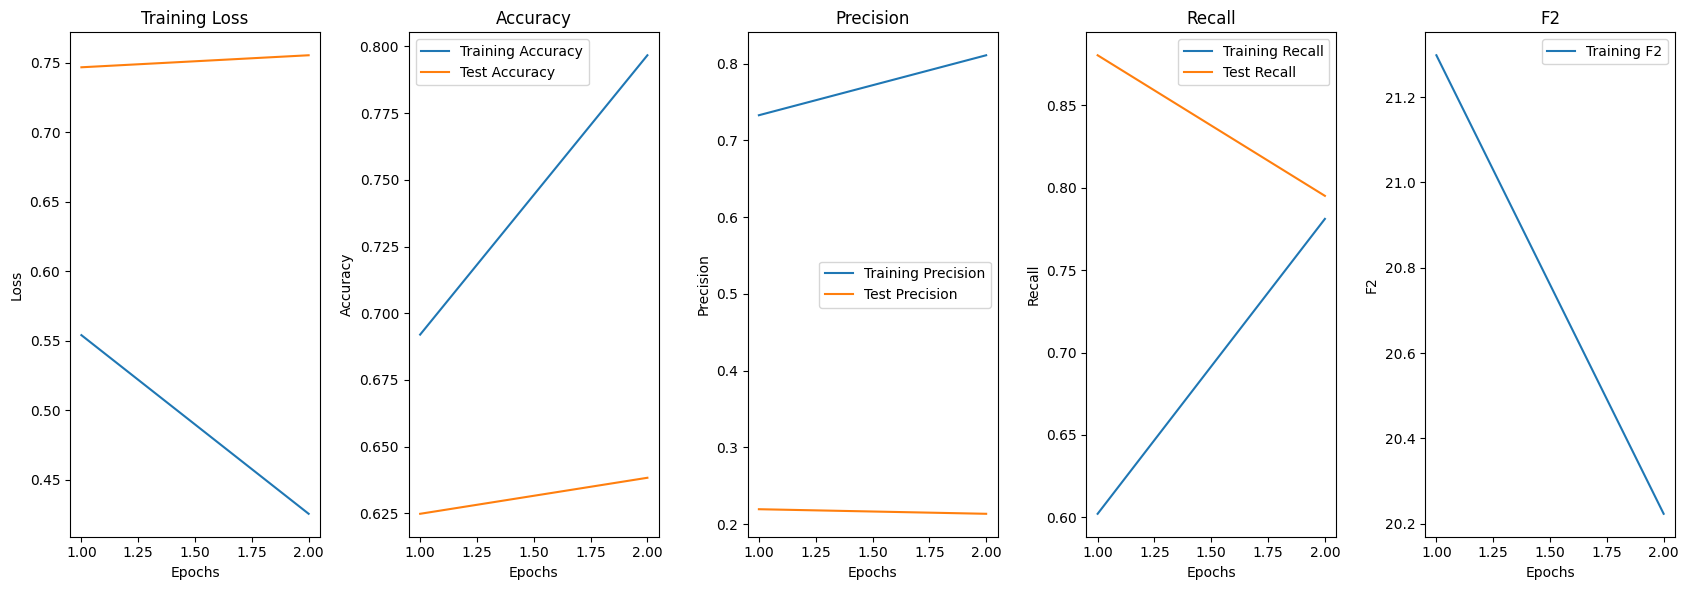

Test Metrics:
  Eval Accuracy: 0.6475366036122688
  Eval Precision: 0.23312101910828026
  Eval Recall: 0.7605985037406484
  Eval F2: 21.7184903868977
Execution time: 84.7105667591095 seconds


In [28]:
#| label: fig-cap-margin
#| fig-cap: "Series of graphs depicting the performance metrics of the model. The metrics include Training Loss, Accuracy, Precision, Recall, and F2 score for both training and testing data."


history = {}  # Initialize an empty dictionary to store training and evaluation history.
BATCH_SIZE = 16  # Define the batch size for data loaders.
LEARNING_RATE = 1e-4  # Set the learning rate for the optimizer.
weight_decay = 1e-2  # Set the weight decay (L2 regularization) for the optimizer.
EPOCHS = 10  # Set the number of epochs for training.

# Prepare the dataset dictionary with training and testing samples.
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}

# Get the model, tokenizer, training data loader, and testing data loader.
model, tokz, train_loader, test_loader = get_loader(models['cmb'], data, bs=BATCH_SIZE, use_special_pad_token=True, num_workers=8)

model.to(device)  # Move the model to the specified device (CPU or GPU).

start_time = time.time()  # Record the start time for training.
train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE, early_stopping_patience=2, weight_decay=weight_decay)  # Train the model.
end_time = time.time()  # Record the end time for training.
execution_time = end_time - start_time  # Calculate the execution time for training.

clear_output()  # Clear the output (useful in Jupyter notebooks to clear previous outputs).
print("Execution time:", execution_time, "seconds")  # Print the execution time for training.

start_time = time.time()  # Record the start time for evaluation.
# Evaluate the model on the validation dataset and optionally plot the training history.
evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = BATCH_SIZE * 2, plot_train=True)
end_time = time.time()  # Record the end time for evaluation.
execution_time = end_time - start_time  # Calculate the execution time for evaluation.
print("Execution time:", execution_time, "seconds")  # Print the execution time for evaluation.

Based on the performance of the model on two epochs, we can make the following analysis:

1. **Training Loss**: Decreases from approximately 0.55 to 0.45, indicating improved performance during training.
2. **Accuracy**: Shows a significant increase for training accuracy from about 0.70 to 0.78, while test accuracy slightly improves from around 0.62 to 0.64.
3. **Precision**: Training precision rises from about 0.75 to 0.80, whereas test precision remains almost constant at around 0.21.
4. **Recall**: Training recall increases from 0.60 to 0.75, while test recall decreases from 0.85 to 0.70, suggesting potential overfitting.
5. **F2**: Indicates a decline in the F2 score from approximately 21.2 to 20.2, which means that the model is not generalizing from the training data to the test data.

###### Test Metrics:
1. **Eval Accuracy**: 0.6475, which indicates the model's ability to correctly predict test data is moderate but lower compared to training accuracy.
2. **Eval Precision**: 0.2331, which is significantly lower than the training precision, suggesting the model struggles with false positives on the test set.
3. **Eval Recall**: 0.7606, which is relatively high and close to the training recall, showing the model still performs well in identifying most positive instances on the test set.
4. **Eval F2**: 21.7185, which remains high, indicating that despite high recall, the model struggles with false positives.

###### Conclusion:
- **Overfitting**: The discrepancy between training and test precision suggests overfitting. The model performs well on the training data but struggles with generalization, leading to lower performance on unseen data. 
- **F2 score**: The model prioritizes recall over precision. This is evident from the high recall but low precision on the test set. This behavior is further reflected in the F2 score, which is low, indicating many false positives.

This analysis suggest that there is a problem with our model, because we need a model that should perform well on unseen data with low errors.

###### Why is this important?
Well, imagine that we will deploy our model in a real-world application. We don't want to miss comments that might receive a response because we could use them to increase traffic on our site or social media. In that case, a model that detects positive instances well with minimal false positives is acceptable. However, our model currently has many false positives, which can be problematic.

###### Practical Implications:
- Business Impact: If the model is used in an application like content moderation or customer feedback analysis, high false positives mean that many irrelevant comments would be flagged for response. This can lead to inefficient use of resources and missed opportunities to engage with truly relevant comments.
- User Experience: In applications like spam detection, a high number of false positives can frustrate users, as legitimate messages may be incorrectly flagged as spam.
- Operational Efficiency: For customer service applications, responding to false positives wastes time and effort that could be better spent addressing genuine issues.

But, let's try with more data in our training set to see the impact on the model performance. We will initialise a new model and train it on 10000 comments. 

In [ ]:
X_train, y_train = train['message'], train['target']
X_train_sample, y_train_sample = equal_class_sampling(X_train, y_train, 10000)
_, X_test_sample, _, y_test_sample = train_test_split(X_valid, y_valid, test_size=0.02, random_state=42)

Execution time: 1122.6102643013 seconds


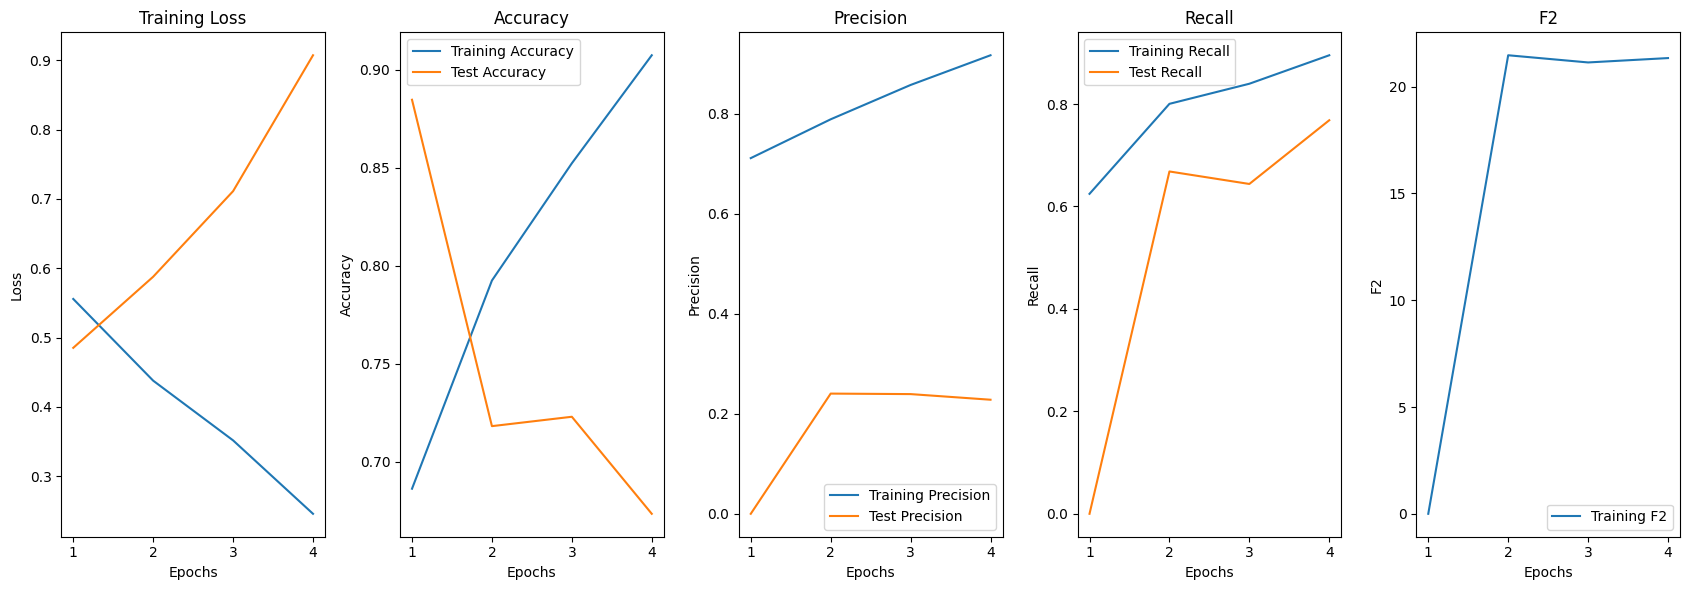

Test Metrics:
  Eval Accuracy: 0.6856898578604254
  Eval Precision: 0.25793871866295265
  Eval Recall: 0.769742310889443
  Eval F2: 23.946211533488494
Execution time: 84.70709776878357 seconds


In [30]:
#| label: fig-cap-margin2
#| fig-cap: "Series of graphs depicting the performance metrics of the model. The metrics include Training Loss, Accuracy, Precision, Recall, and F2 score for both training and testing data."

history = {}
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
weight_decay = 1e-2
EPOCHS = 10
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['cmb'], data, bs=BATCH_SIZE, use_special_pad_token=True, num_workers=8)
model.to(device)

start_time = time.time()
train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE, early_stopping_patience=2, weight_decay=weight_decay)
end_time = time.time()
execution_time = end_time - start_time

clear_output()
print("Execution time:", execution_time, "seconds")

start_time = time.time()
evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = BATCH_SIZE * 2, plot_train=True)
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

The F2 score improved from 21% to 23%. But can we conclude that it's the increased training set that induces these results?

Let's try it with a larger training set. 

In [ ]:
X_train, y_train = train['message'], train['target']
X_train_sample, y_train_sample = equal_class_sampling(X_train, y_train, 15000)
_, X_test_sample, _, y_test_sample = train_test_split(X_valid, y_valid, test_size=0.02, random_state=42)

Execution time: 1914.5363965034485 seconds


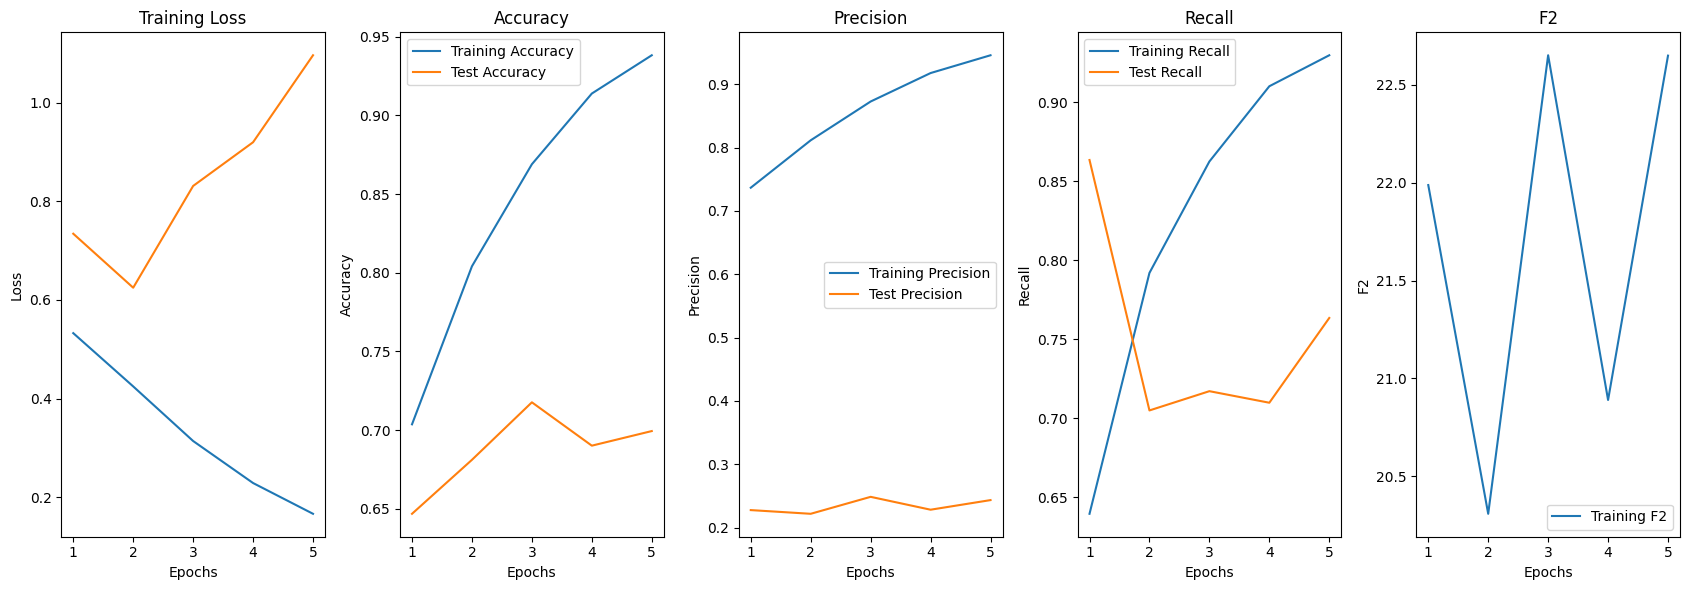

Test Metrics:
  Eval Accuracy: 0.7079192048733568
  Eval Precision: 0.26705237515225333
  Eval Recall: 0.7290108063175395
  Eval F2: 24.293628808864266
Execution time: 85.33442664146423 seconds


In [35]:
#| label: fig-cap-margin3
#| fig-cap: "Series of graphs depicting the performance metrics of the model. The metrics include Training Loss, Accuracy, Precision, Recall, and F2 score for both training and testing data."

history = {}
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
weight_decay = 1e-2
EPOCHS = 10
data = {'X_train': X_train_sample, 'y_train': y_train_sample, 'X_test': X_test_sample, 'y_test': y_test_sample}
model, tokz, train_loader, test_loader = get_loader(models['cmb'], data, bs=BATCH_SIZE, use_special_pad_token=True, num_workers=8)
model.to(device)

start_time = time.time()
train_model(model, train_loader, test_loader, history, num_epochs=EPOCHS, lr=LEARNING_RATE, early_stopping_patience=2, weight_decay=weight_decay)
end_time = time.time()
execution_time = end_time - start_time

clear_output()
print("Execution time:", execution_time, "seconds")

start_time = time.time()
evaluate_model(tokz, model, (X_valid_sample, y_valid_sample), history, device, bs = BATCH_SIZE * 2, plot_train=True)
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

On test set, the F2 score of the model improve again from 23% to 24%. 

###### Conclusion:
The increase in the training set size helps the model generalize better to the test data, reducing overfitting and improving its ability to balance precision and recall effectively.

## Takeaways

1. **Dataset Analysis is Crucial**: Always begin by analyzing your dataset. Understanding the distribution and characteristics of your data helps in making informed decisions about model training and evaluation. In scenarios with limited resources, generating more data for the underrepresented class might not be feasible. Instead, sampling equal numbers of comments from each class for the training set can help reduce bias towards the overrepresented class.

2. **Balanced Training, Unbalanced Validation**: While balancing the training set by equal sampling is important to reduce bias, the validation set should remain unbalanced. This approach ensures that the model's performance is evaluated in a realistic manner, reflecting its ability to generalize to the true distribution of the data.

3. **Resource-Based Training Strategy**: Define your training strategy based on the available resources. When computational power or time is limited, working with a smaller, balanced sample of the dataset is a practical approach. This allows for iterative experimentation and tuning without the overhead of processing the entire dataset.

4. **Problem-Specific Metrics**: Choose evaluation metrics that align with your problem's objectives. For instance, in this scenario, the F2 score (F2 = tp / (tp + 2 * fn + fp)) is used to evaluate model performance by balancing the detection of the positive class and minimizing errors.

5. **Initial Model Performance**: After the first round of training, the F2 score indicates that the model prioritizes recall over precision. This is evidenced by the high recall but low precision on the test set.

6. **Impact of False Positives**: High false positives can be problematic in real-world applications. They can lead to inefficient use of resources and missed opportunities to engage with truly relevant comments. This highlights the need for a balance between precision and recall.

7. **Training Set Size and Generalization**: Increasing the size of the training set helps the model generalize better to the test data. A larger training set reduces overfitting and enhances the model's ability to balance precision and recall effectively. This results in improved overall performance and more reliable predictions.

8. **Choosing the Right Model**: Select a model that is suitable for your specific problem. For instance, since the dataset consists of French text, using CamemBERT, a model specifically designed for the French language, is an appropriate choice.

9. **Hyperparameter Tuning**: Finding the optimal hyperparameters for your model is crucial and often involves extensive experimentation. Before finalizing the model, numerous combinations were tested to identify the best-performing configuration. Hyperparameter tuning is more of an art than a strict recipe, requiring intuition and experience to achieve the best results.